#  2. Hands on SSL

In [1]:
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Activation
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [2]:
def plot_results(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.tight_layout(pad=4)
    fig.suptitle(title)

    ax1.set_title('Accuracy')
    ax1.plot(acc)
    ax1.plot(val_acc)
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['training', 'validation'], loc='lower right')

    ax2.set_title('Loss')
    ax2.plot(loss)
    ax2.plot(val_loss)
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['training', 'validation'], loc='upper right')

    fig.show()

## 2.1 prepare data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [4]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [5]:
EPOCHS = 40
BATCH_SIZE = 32
NUM_CLASSES = 10
INPUT_SHAPE = x_train.shape[1:]

In [6]:
unlabeld_index = np.ones(y_train.shape, np.bool)

N = 20
for i in range(10):
  idx = np.where(y_train == i)[0][:N]
  unlabeld_index[idx] = 0

In [7]:
x_unlabeld = x_train[np.where(unlabeld_index)[0], ...]

x_train = x_train[np.where(~unlabeld_index)[0], ...]
y_train = y_train[np.where(~unlabeld_index)[0], ...]

y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)

In [8]:
# examples of categorical crossentropy
cce = CategoricalCrossentropy()

# a labeled data from the second class
y_true = [[0, 1, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# an ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# another ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.1, 0.4, 0.3, 0.2]]
print(cce(y_true, y_pred).numpy())

0.051293306
0.0
0.0


## Model Structure

In [9]:
def model_structure(input_shape=INPUT_SHAPE):
    # Model Structure
    input = Input(
        shape=(input_shape),
    )

    # Block 1
    x = Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation='relu',
    )(input)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(
        pool_size=(3, 3),
    )(x)
    x = Dropout(rate=0.2)(x)

    # Block 2
    x = Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation='relu',
    )(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(
        pool_size=(2, 2),
    )(x)
    x = Dropout(rate=0.2)(x)

    # Block 3
    x = Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation='relu',
    )(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(
        pool_size=(2, 2),
    )(x)
    x = Dropout(rate=0.2)(x)

    # FC
    x = Flatten()(x)
    x = Dense(units=1024, activation='relu')(x)
    x = BatchNormalization()(x)
    output = Dropout(rate=0.2)(x)

    model = Model(inputs=input, outputs=output, name='core')
    return model

In [10]:
model_structure().summary()

Model: "core"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 10, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496  

## Part A

In [11]:
core_model = model_structure()
model = Sequential([
    core_model,
    Dense(units=10, activation='softmax'),
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 core (Functional)           (None, 1024)              230336    
                                                                 
 dense_2 (Dense)             (None, 10)                10250     
                                                                 
Total params: 240,586
Trainable params: 238,090
Non-trainable params: 2,496
_________________________________________________________________


In [12]:
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=[x_test, y_test],
)

Epoch 1/40
7/7 [==============================] - 14s 280ms/step - loss: 3.0487 - accuracy: 0.1050 - val_loss: 2.2981 - val_accuracy: 0.1470
Epoch 2/40
7/7 [==============================] - 1s 197ms/step - loss: 2.1521 - accuracy: 0.2850 - val_loss: 2.2959 - val_accuracy: 0.1059
Epoch 3/40
7/7 [==============================] - 1s 205ms/step - loss: 1.9186 - accuracy: 0.4100 - val_loss: 2.3042 - val_accuracy: 0.0994
Epoch 4/40
7/7 [==============================] - 1s 221ms/step - loss: 1.8176 - accuracy: 0.4400 - val_loss: 2.3224 - val_accuracy: 0.1004
Epoch 5/40
7/7 [==============================] - 1s 222ms/step - loss: 1.6209 - accuracy: 0.4400 - val_loss: 2.3424 - val_accuracy: 0.1010
Epoch 6/40
7/7 [==============================] - 1s 209ms/step - loss: 1.3520 - accuracy: 0.5150 - val_loss: 2.3660 - val_accuracy: 0.1114
Epoch 7/40
7/7 [==============================] - 1s 222ms/step - loss: 1.4039 - accuracy: 0.5300 - val_loss: 2.3911 - val_accuracy: 0.1006
Epoch 8/40
7/7 [===

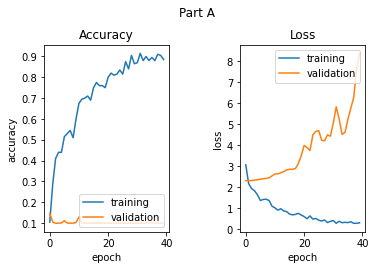

In [13]:
plot_results(history, title='Part A')

## Part B
4 Classes: 0, 90, 180, 270

In [14]:
def rotate(x, deg):
    if deg == 0:
        return x

    elif deg == 90:
        return np.rot90(x)

    elif deg == 180:
        return np.rot90(np.rot90(x))

    else:
        return np.rot90(np.rot90(np.rot90(x)))

In [15]:
x_train_rotate = np.zeros_like(x_unlabeld)
y_train_rotate = np.zeros((x_unlabeld.shape[0], 4))

labels = [0, 1, 2, 3]
degrees = [0, 90, 180, 270]

for i in range(x_train_rotate.shape[0]):
    label = random.choices(labels, weights=[1, 3, 3, 3], k=1)[0]
    deg = degrees[label]
    rotated_image = rotate(x_unlabeld[i], deg)

    x_train_rotate[i] = rotated_image
    y_train_rotate[i] = to_categorical(label, num_classes=4)

[0. 0. 0. 1.]


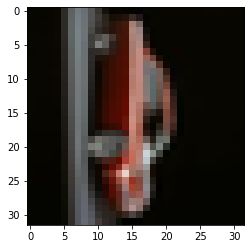


[0. 0. 0. 1.]


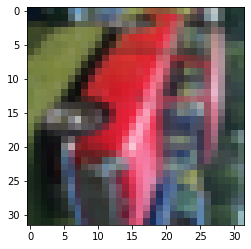

In [16]:
for i in range(2):
    x = x_train_rotate[i]
    y = y_train_rotate[i]
    plt.imshow(x, interpolation='nearest')
    print(y)
    plt.show()
    print()

In [17]:
core_model = model_structure()
model = Sequential([
    core_model,
    Dense(units=4, activation='softmax'),
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 core (Functional)           (None, 1024)              230336    
                                                                 
 dense_4 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 234,436
Trainable params: 231,940
Non-trainable params: 2,496
_________________________________________________________________


In [18]:
history = model.fit(
    x_train_rotate,
    y_train_rotate,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)

Epoch 1/40
1245/1245 [==============================] - 15s 11ms/step - loss: 1.2563 - accuracy: 0.4854 - val_loss: 1.0655 - val_accuracy: 0.5434
Epoch 2/40
1245/1245 [==============================] - 14s 11ms/step - loss: 1.0509 - accuracy: 0.5612 - val_loss: 1.0355 - val_accuracy: 0.5706
Epoch 3/40
1245/1245 [==============================] - 13s 11ms/step - loss: 1.0013 - accuracy: 0.5841 - val_loss: 0.9428 - val_accuracy: 0.6140
Epoch 4/40
1245/1245 [==============================] - 14s 11ms/step - loss: 0.9556 - accuracy: 0.6091 - val_loss: 0.8701 - val_accuracy: 0.6492
Epoch 5/40
1245/1245 [==============================] - 14s 11ms/step - loss: 0.9180 - accuracy: 0.6242 - val_loss: 0.9157 - val_accuracy: 0.6231
Epoch 6/40
1245/1245 [==============================] - 14s 11ms/step - loss: 0.8875 - accuracy: 0.6424 - val_loss: 0.8375 - val_accuracy: 0.6701
Epoch 7/40
1245/1245 [==============================] - 14s 11ms/step - loss: 0.8662 - accuracy: 0.6481 - val_loss: 0.8060 -

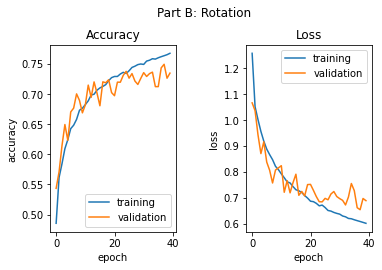

In [19]:
plot_results(history, title='Part B: Rotation')

In [20]:
new_model = Sequential([
    model.layers[0],
    Dense(units=10, activation='softmax'),
])

new_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy'],
)

new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 core (Functional)           (None, 1024)              230336    
                                                                 
 dense_5 (Dense)             (None, 10)                10250     
                                                                 
Total params: 240,586
Trainable params: 238,090
Non-trainable params: 2,496
_________________________________________________________________


In [21]:
history = new_model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=[x_test, y_test],
)

Epoch 1/40
7/7 [==============================] - 3s 314ms/step - loss: 2.3457 - accuracy: 0.0950 - val_loss: 2.3182 - val_accuracy: 0.0941
Epoch 2/40
7/7 [==============================] - 1s 222ms/step - loss: 2.3343 - accuracy: 0.0800 - val_loss: 2.3058 - val_accuracy: 0.1052
Epoch 3/40
7/7 [==============================] - 1s 207ms/step - loss: 2.2939 - accuracy: 0.1450 - val_loss: 2.2943 - val_accuracy: 0.1154
Epoch 4/40
7/7 [==============================] - 1s 211ms/step - loss: 2.2949 - accuracy: 0.1000 - val_loss: 2.2836 - val_accuracy: 0.1256
Epoch 5/40
7/7 [==============================] - 1s 223ms/step - loss: 2.2631 - accuracy: 0.1550 - val_loss: 2.2736 - val_accuracy: 0.1353
Epoch 6/40
7/7 [==============================] - 1s 210ms/step - loss: 2.2669 - accuracy: 0.1500 - val_loss: 2.2641 - val_accuracy: 0.1441
Epoch 7/40
7/7 [==============================] - 1s 223ms/step - loss: 2.2398 - accuracy: 0.1550 - val_loss: 2.2549 - val_accuracy: 0.1531
Epoch 8/40
7/7 [====

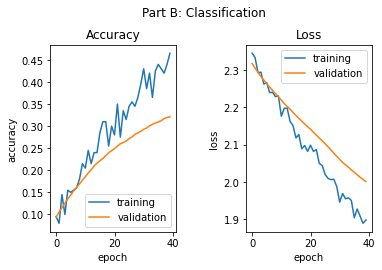

In [22]:
plot_results(history, title='Part B: Classification')

## Part C
Model with two outputs: Class, Rotate

In [23]:
def plot(history, section):
    plt.plot(history.history[section])
    if section != 'rotator_loss' and section != 'rotator_accuracy':
        plt.plot(history.history['val_' + section])
    plt.title(section)
    plt.ylabel(section)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print()

def plot_all(history):
    plot(history, 'rotator_loss')
    plot(history, 'rotator_accuracy')
    plot(history, 'classifier_loss')
    plot(history, 'classifier_accuracy')
    plot(history, 'loss')

In [24]:
def create_model():
    core_model = Sequential([model_structure()])

    classifier = Dense(
        units=10,
        activation='softmax',
        name='classifier'
    )(core_model.outputs[0])

    rotator = Dense(
        units=4,
        activation='softmax',
        name='rotator'
    )(core_model.outputs[0])

    two_out_model = Model(
        inputs=core_model.inputs,
        outputs=[classifier, rotator]
    )

    return two_out_model

In [25]:
create_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 core_input (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 core (Functional)              (None, 1024)         230336      ['core_input[0][0]']             
                                                                                                  
 classifier (Dense)             (None, 10)           10250       ['core[0][0]']                   
                                                                                                  
 rotator (Dense)                (None, 4)            4100        ['core[0][0]']                   
                                                                                              

In [26]:
y_train_class = np.concatenate((y_train, np.zeros((x_train_rotate.shape[0], 10))), axis=0)
y_train_rot = np.concatenate((np.zeros((y_train.shape[0], 4)), y_train_rotate), axis=0)

x_train_all = np.concatenate((x_train, x_train_rotate), axis=0)
y_train_all = [y_train_class, y_train_rot]

print(x_train_all.shape)
print(y_train_all[0].shape)
print(y_train_all[1].shape)

(50000, 32, 32, 3)
(50000, 10)
(50000, 4)


In [30]:
two_out_model = create_model()

two_out_model.compile(
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'],
    loss_weights={
        'classifier': 10,
        'rotator': 1
    },
    loss=CategoricalCrossentropy(),
)

history = two_out_model.fit(
    x_train_all,
    y_train_all,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(x_test, {'classifier': y_test})
)

Epoch 1/10
1563/1563 [==============================] - 19s 11ms/step - loss: 1.6495 - classifier_loss: 0.0104 - rotator_loss: 1.5454 - classifier_accuracy: 0.0903 - rotator_accuracy: 0.3392 - val_loss: 24.1498 - val_classifier_loss: 2.4150 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.1080 - val_rotator_accuracy: 0.0000e+00
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.7480 - classifier_loss: 0.0158 - rotator_loss: 1.5902 - classifier_accuracy: 0.0940 - rotator_accuracy: 0.3616 - val_loss: 26.5699 - val_classifier_loss: 2.6570 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.0964 - val_rotator_accuracy: 0.0000e+00
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.8576 - classifier_loss: 0.0194 - rotator_loss: 1.6636 - classifier_accuracy: 0.0929 - rotator_accuracy: 0.3531 - val_loss: 26.5003 - val_classifier_loss: 2.6500 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.0850 - val_rotato

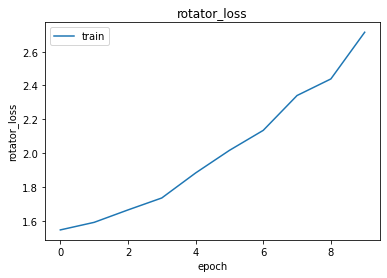

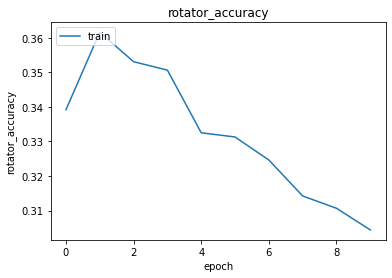

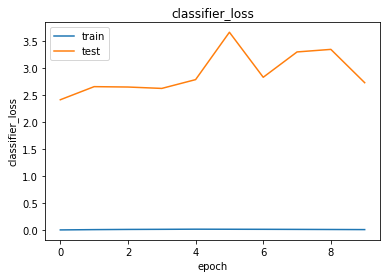

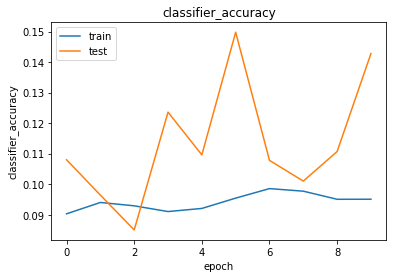

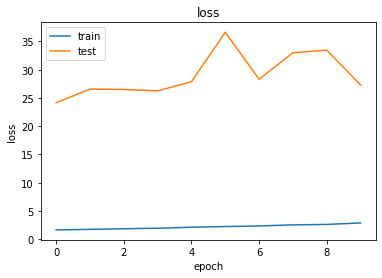

In [31]:
plot_all(history)

In [32]:
two_out_model = create_model()

two_out_model.compile(
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'],
    loss_weights={
        'classifier': 1,
        'rotator': 10
    },
    loss=CategoricalCrossentropy(),
)

history = two_out_model.fit(
    x_train_all,
    y_train_all,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(x_test, {'classifier': y_test})
)

Epoch 1/10
1563/1563 [==============================] - 19s 11ms/step - loss: 13.2583 - classifier_loss: 0.0103 - rotator_loss: 1.3248 - classifier_accuracy: 0.1048 - rotator_accuracy: 0.4581 - val_loss: 2.4594 - val_classifier_loss: 2.4594 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.0708 - val_rotator_accuracy: 0.0000e+00
Epoch 2/10
1563/1563 [==============================] - 18s 11ms/step - loss: 14.6629 - classifier_loss: 0.0134 - rotator_loss: 1.4649 - classifier_accuracy: 0.0967 - rotator_accuracy: 0.4290 - val_loss: 2.8760 - val_classifier_loss: 2.8760 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.1028 - val_rotator_accuracy: 0.0000e+00
Epoch 3/10
1563/1563 [==============================] - 18s 11ms/step - loss: 15.9427 - classifier_loss: 0.0161 - rotator_loss: 1.5927 - classifier_accuracy: 0.1018 - rotator_accuracy: 0.4026 - val_loss: 2.5341 - val_classifier_loss: 2.5341 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.0730 - val_rotato

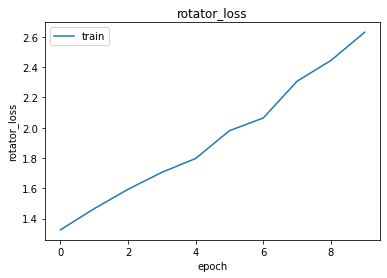

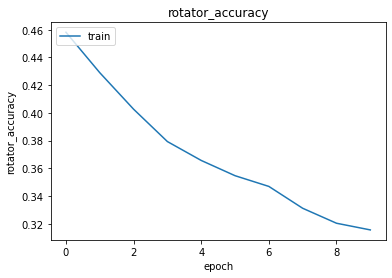

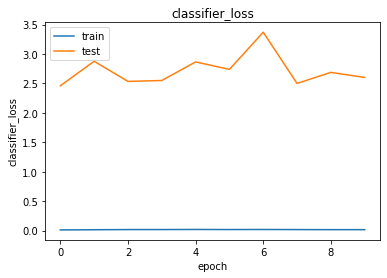

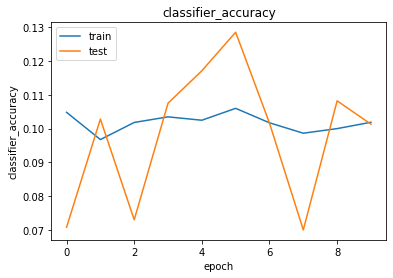

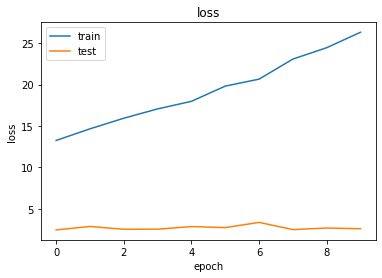

In [33]:
plot_all(history)

In [34]:
two_out_model = create_model()

two_out_model.compile(
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'],
    loss_weights={
        'classifier': 1,
        'rotator': 1
    },
    loss=CategoricalCrossentropy(),
)

history = two_out_model.fit(
    x_train_all,
    y_train_all,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(x_test, {'classifier': y_test})
)

Epoch 1/10
1563/1563 [==============================] - 19s 11ms/step - loss: 1.4762 - classifier_loss: 0.0109 - rotator_loss: 1.4654 - classifier_accuracy: 0.0915 - rotator_accuracy: 0.3930 - val_loss: 2.3670 - val_classifier_loss: 2.3670 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.1070 - val_rotator_accuracy: 0.0000e+00
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.5700 - classifier_loss: 0.0148 - rotator_loss: 1.5552 - classifier_accuracy: 0.0961 - rotator_accuracy: 0.3654 - val_loss: 2.5515 - val_classifier_loss: 2.5515 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.0798 - val_rotator_accuracy: 0.0000e+00
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.6949 - classifier_loss: 0.0178 - rotator_loss: 1.6771 - classifier_accuracy: 0.0976 - rotator_accuracy: 0.3579 - val_loss: 2.6058 - val_classifier_loss: 2.6058 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.1293 - val_rotator_a

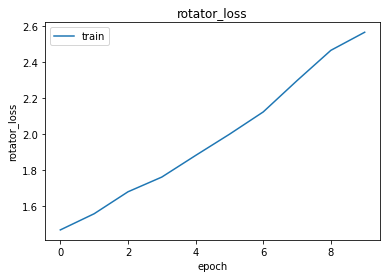

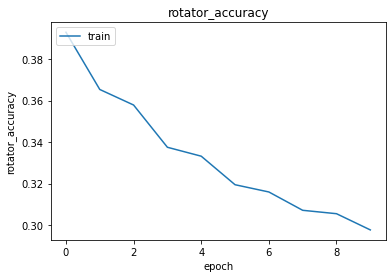

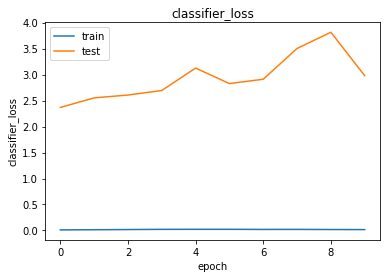

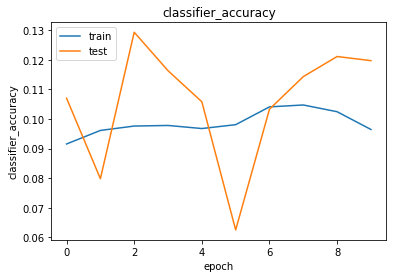

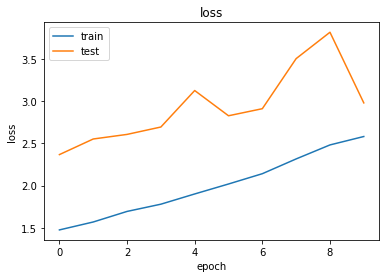

In [35]:
plot_all(history)